In [366]:
import numpy as np
import scipy
import scipy.stats
import scipy.sparse
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import NearestNeighbors
import time
import os
import json
from datetime import datetime
import matplotlib
matplotlib.use('PS')
import matplotlib.pyplot as plt
%matplotlib inline
import scanpy as sc
import pandas as pd
from distutils.version import LooseVersion, StrictVersion
from collections import Counter
import seaborn as sns
import umap

In [367]:
from matplotlib import rc
plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':['FreeSans']})
plt.rcParams['pdf.fonttype'] = 42

# Load data

In [369]:
data_dir = './Data/'
plot_dir = './Plots/'
data = pd.read_csv(data_dir+'hwf_clean_2020-05-12.csv', dtype=str)
data.shape

(3661716, 186)

In [370]:
# Create variable for feeling not_well
data['feeling_not_well'] = data['feeling']=='not_well'

# Version 1: All responses

In [371]:
# Use all symptoms associated with feeling unwell that are present in all surveys
symptoms = ['not_well_symptoms_chills_shaking',
            'not_well_symptoms_diarrhea',
            'not_well_symptoms_dry_cough',
            'not_well_symptoms_fever',
            'not_well_symptoms_loss_of_appetite',
            'not_well_symptoms_loss_of_taste_and_or_smell',
            'not_well_symptoms_muscle_and_joint_pain',
            'not_well_symptoms_nasal_congestion',
            'not_well_symptoms_nausea_and_vomiting',
            'not_well_symptoms_runny_nose',
            'not_well_symptoms_shortness_of_breath',
            'not_well_symptoms_sore_throat',
            'not_well_symptoms_tight_feeling_in_chest',
            'not_well_symptoms_wet_cough',
            'symptoms_well_chills',
            'symptoms_well_cough',
            'symptoms_well_headache',
            'symptoms_well_loss_of_taste_and_or_smell',
            'symptoms_well_low_grade_fever',
            'symptoms_well_mild_fatigue',
            'symptoms_well_muscle_and_joint_pain',
            'symptoms_well_nasal_congestion',
            'symptoms_well_runny_nose',
            'symptoms_well_tight_feeling_in_chest',
            'feeling_not_well']

# Chose not to include continuous var: 'fever_temp_f'

symptom_data = np.zeros((data.shape[0], len(symptoms)))

for i,symptom in enumerate(symptoms):
    
    if symptom=='feeling_not_well':
        symptom_data[:,i][data[symptom]==True] = 1
    else:
        symptom_data[:,i][data[symptom]=='True'] = 1
  

In [372]:
# Remove responses with no responses on the symptom variables shared across all surveys (excluding feeling not well)
idx = np.sum(symptom_data[:,:23],axis=1)>0 
symptom_data = symptom_data[idx,:]

In [373]:
symptom_data.shape

(667651, 25)

### UMAP

In [374]:
reducer = umap.UMAP(n_neighbors=1000, min_dist=0.5, metric='hamming') # n_neighbors=5, min_dist=0.3, metric='correlation'
embedding = reducer.fit_transform(symptom_data)
# n_neighbors=500 for main rigure

/opt/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


### Plot 1: UMAP with COVID-19 test labels

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


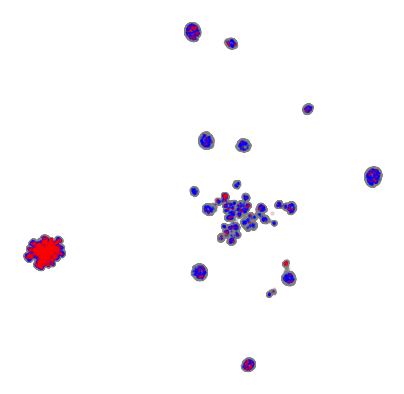

In [388]:
# Get indices of positive and negative test results
data_plotted = data.iloc[idx]
v4_idx = data_plotted['survey_version']=='4'
a = data_plotted['covid_19_test_result']
a[v4_idx] = '' # exclude antibody tests
b = data_plotted['covid_19_swab_test_result']

pos_idx = np.logical_or(a=='positive', b=='positive')
neg_idx = np.logical_or(a=='negative', b=='negative')
x = embedding[:,0]
y = embedding[:,1]

plt.figure(figsize=(7,7))
plt.scatter(x,y,10,'gray',label='No test', alpha=0.25)
plt.scatter(x[neg_idx],y[neg_idx],2,'blue',label='Negative', alpha=0.3)
plt.scatter(x[pos_idx],y[pos_idx],2,'r',label='Positive', alpha=0.3)
plt.xticks([], [])
plt.yticks([], [])
#plt.legend(frameon=False, markerscale=2.5, prop={'size': 18})
plt.axis('off')
plt.savefig(plot_dir+'UMAP_tests.png',dpi=300)

### Plot 2: UMAP with general 'well' versus 'not-well' status

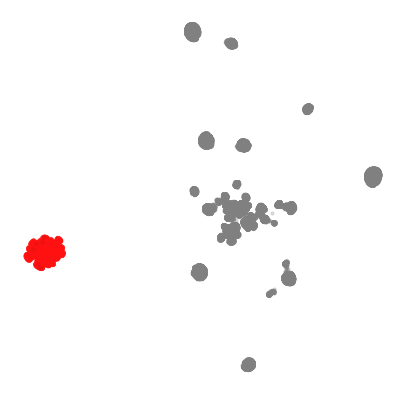

In [389]:
a = data['feeling']=='well'
a = a[idx]
well_idx = a#[-10000:]
not_well_idx = well_idx==False

x = embedding[:,0]
y = embedding[:,1]
plt.figure(figsize=(7,7))
plt.scatter(x[well_idx],y[well_idx],10,'gray',label='Feeling well', alpha=0.25)
plt.scatter(x[not_well_idx],y[not_well_idx],10,'red',label='Not well', alpha=0.05)
plt.xticks([], [])
plt.yticks([], [])
plt.axis('off')
#plt.legend(frameon=False, markerscale=2.5, loc='upper right', prop={'size': 14})
plt.savefig(plot_dir+'UMAP_feeling_not_well.png',dpi=300)

### Plot 3: UMAP subplots showing aggregate or individual CDC-defined COVID-19 symptoms

In [378]:
# 
orig_symptoms = ['not_well_symptoms_chills_shaking', # 0
    'not_well_symptoms_diarrhea', # 1
    'not_well_symptoms_dry_cough', # 2
    'not_well_symptoms_fever', # 3
    'not_well_symptoms_loss_of_appetite', # 4
    'not_well_symptoms_loss_of_taste_and_or_smell', # 5
    'not_well_symptoms_muscle_and_joint_pain', # 6
    'not_well_symptoms_nasal_congestion', # 7
    'not_well_symptoms_nausea_and_vomiting', # 8
    'not_well_symptoms_runny_nose', # 9
    'not_well_symptoms_shortness_of_breath', # 10
    'not_well_symptoms_sore_throat', # 11
    'not_well_symptoms_tight_feeling_in_chest', # 12
    'not_well_symptoms_wet_cough', # 13
    'symptoms_well_chills', # 14
    'symptoms_well_cough', # 15
    'symptoms_well_headache', # 16
    'symptoms_well_loss_of_taste_and_or_smell', # 17
    'symptoms_well_low_grade_fever', # 18
    'symptoms_well_mild_fatigue', # 19
    'symptoms_well_muscle_and_joint_pain', # 20
    'symptoms_well_nasal_congestion', # 21
    'symptoms_well_runny_nose', # 22
    'symptoms_well_tight_feeling_in_chest', # 24
    'feeling_not_well'] # 25

CDC_symptoms = ['cough', # 0
                'shortness_of_breath', # 1
                'fever', # 2
                'chills_shaking', # 3
                'muscle_and_joint_pain', # 4
                'diarrhea', # 5
                'sore_throat', # 6
                'loss_of_taste_and_or_smell'] # 7

# ACTUAL CDC CRITERIA
# Cough
# Shortness of breath or difficulty breathing
# Fever
# Chills
# Muscle pain
# Sore throat
# New loss of taste or smell

CDC_symptom_data = np.zeros((symptom_data.shape[0], len(CDC_symptoms)))
CDC_symptom_data[:,0] = symptom_data[:,2] + symptom_data[:,13]
CDC_symptom_data[:,1] = symptom_data[:,10]
CDC_symptom_data[:,2] = symptom_data[:,3]
CDC_symptom_data[:,3] = symptom_data[:,0]
CDC_symptom_data[:,4] = symptom_data[:,6]
CDC_symptom_data[:,5] = symptom_data[:,1]
CDC_symptom_data[:,6] = symptom_data[:,11]
CDC_symptom_data[:,7] = symptom_data[:,5] + symptom_data[:,17]


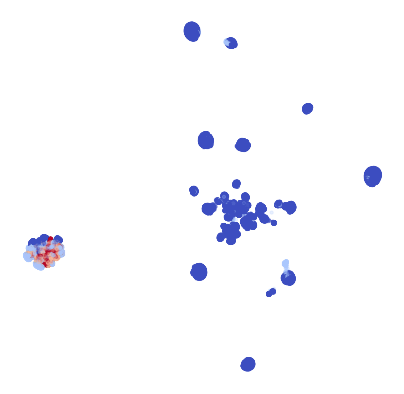

In [390]:
# Plot UMAP with aggregate CDC symptoms
CDC_symptom_aggregate = np.sum(CDC_symptom_data, axis=1)
x = embedding[:,0]
y = embedding[:,1]
z = CDC_symptom_aggregate
xyz= np.transpose(np.array([x, y, z]))
xyz[xyz[:,2].argsort()] # sort by CDC aggregate

plt.figure(figsize=(7,7))
#plt.scatter(x,y,10,CDC_symptom_aggregate,cmap='gray',vmax=3, alpha=0.1)
plt.scatter(xyz[:,0],xyz[:,1],10,xyz[:,2],cmap='coolwarm',vmax=3, alpha=0.25)
plt.xticks([], [])
plt.yticks([], [])
plt.axis('off')
#cb = plt.colorbar(ticks=[0, 1, 2, 3])
cb.ax.tick_params(labelsize=20)
#cb.set_label(label='# CDC COVID-19 symptoms', size=26)
plt.savefig(plot_dir+'UMAP_CDC_symptoms.png',dpi=300)

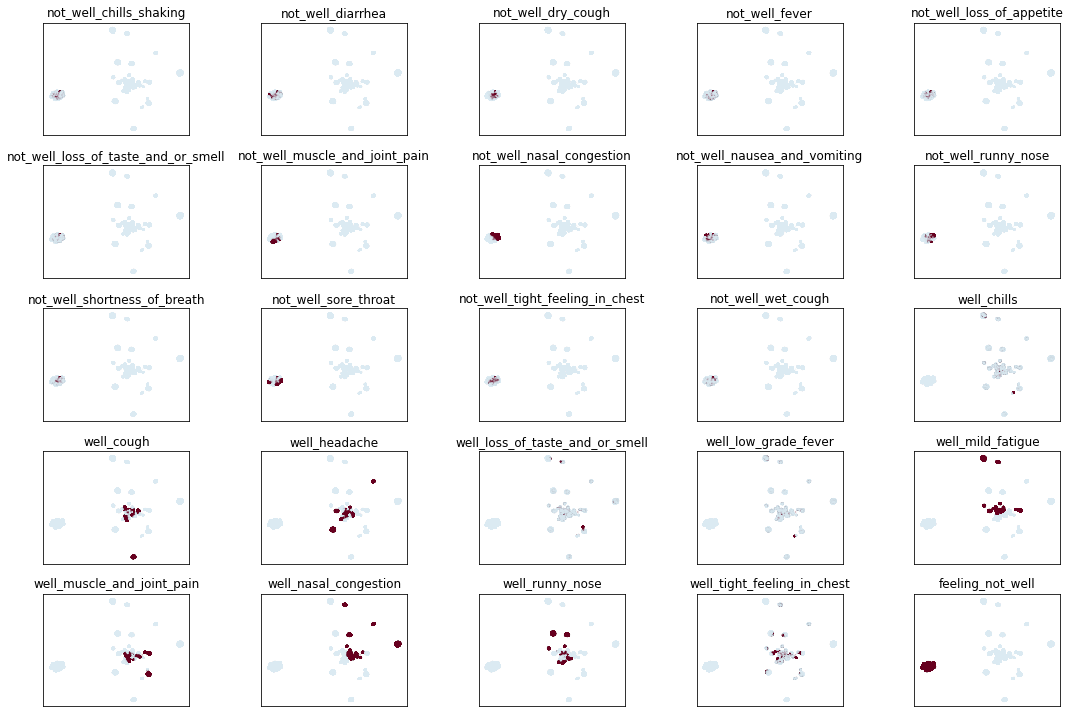

In [392]:
# Full symptoms subplots for supplement
symptom_names=['not_well_chills_shaking', 
    'not_well_diarrhea', 
    'not_well_dry_cough', 
    'not_well_fever', 
    'not_well_loss_of_appetite', 
    'not_well_loss_of_taste_and_or_smell', 
    'not_well_muscle_and_joint_pain', 
    'not_well_nasal_congestion', 
    'not_well_nausea_and_vomiting', 
    'not_well_runny_nose', 
    'not_well_shortness_of_breath',
    'not_well_sore_throat', 
    'not_well_tight_feeling_in_chest', 
    'not_well_wet_cough', 
    'well_chills', 
    'well_cough', 
    'well_headache', 
    'well_loss_of_taste_and_or_smell', 
    'well_low_grade_fever', 
    'well_mild_fatigue', 
    'well_muscle_and_joint_pain', 
    'well_nasal_congestion', 
    'well_runny_nose', 
    'well_tight_feeling_in_chest',
    'feeling_not_well'] 

x = embedding[:,0]
y = embedding[:,1]
f = plt.figure(figsize=(15,12))
symptoms_plot = symptoms

for i,symptom in enumerate(symptom_names):
    ax = f.add_subplot(6,5,i+1)
    plt.scatter(x,y, 0.5, c=symptom_data[:,i],cmap='RdBu_r', vmin=-0.75, vmax=1, alpha=0.25)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(symptom, size=12)
    #plt.colorbar()
plt.tight_layout()
plt.savefig(plot_dir+'UMAP_individual_symptoms.png',dpi=300)

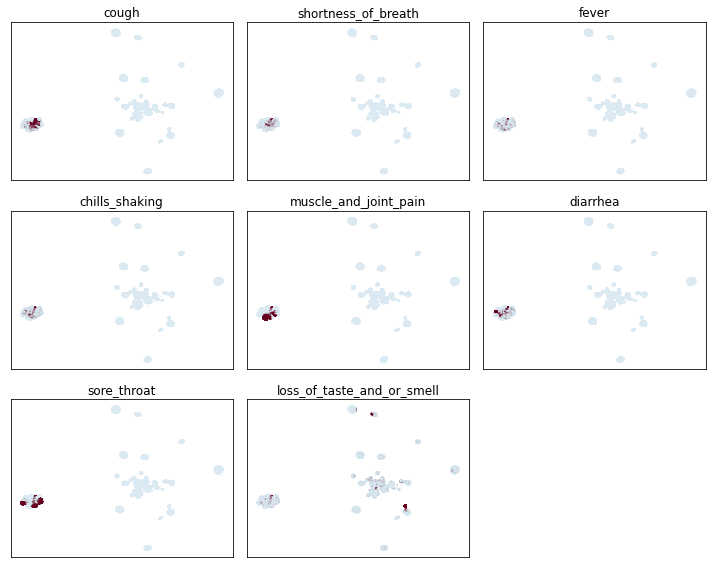

In [381]:
# Plot UMAP with individual CDC symptoms
x = embedding[:,0]
y = embedding[:,1]
f = plt.figure(figsize=(10,8))

for i,symptom in enumerate(CDC_symptoms):
    ax = f.add_subplot(3,3,i+1)
    plt.scatter(x,y, 0.5, c=CDC_symptom_data[:,i],cmap='RdBu_r', vmin=-0.75, vmax=1, alpha=0.25)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(symptom, size=12)
    #plt.colorbar()
plt.tight_layout()